In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix,ConfusionMatrixDisplay

In [2]:
iot23 = pd.read_csv("iot_23_dataset.csv", nrows = 75534)
#uci = pd.read_csv("uci_dataset.csv")
p = LabelEncoder()
iot23.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,1547144801,CTfsE54Xtw73NMFy1f,192.168.1.198,54580,46.201.136.250,23,tcp,-,-,-,...,S0,-,-,0,S,1,40,0,0,Benign
1,1547144817,C1bjes4XYnqoAAq72,192.168.1.198,52458,62.235.223.45,23,tcp,-,-,-,...,S0,-,-,0,S,1,40,0,0,Benign
2,1547144832,CZlL5l4FnAUNl657x4,192.168.1.198,54580,18.98.174.69,23,tcp,-,-,-,...,S0,-,-,0,S,1,40,0,0,Benign
3,1547144801,Cz9mZs2PSXX4TYUohi,192.168.1.198,10803,84.142.131.154,23,tcp,-,-,-,...,S0,-,-,0,S,1,40,0,0,Benign
4,1547144767,CGORSp333qsZ96DSth,192.168.1.198,22568,185.181.179.138,52869,tcp,-,-,-,...,S0,-,-,0,S,1,40,0,0,POHPS


In [3]:
#feature scaling because several of the columns are strings 
iot23['uid'] = p.fit_transform(iot23['uid'])
iot23['id.orig_h'] = p.fit_transform(iot23['id.orig_h'])
iot23['id.resp_h'] = p.fit_transform(iot23['id.resp_h'])
iot23['proto'] = p.fit_transform(iot23['proto'])
iot23['conn_state'] = p.fit_transform(iot23['conn_state'])
iot23['history'] = p.fit_transform(iot23['history'])
iot23['label'] = p.fit_transform(iot23['label']) 
iot23 = iot23.drop(columns=['service', 'duration', 'orig_bytes', 'resp_bytes', 'local_orig', 'local_resp'])
iot23.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,1547144801,36130,0,54580,54899,23,1,3,0,3,1,40,0,0,0
1,1547144817,1892,0,52458,56877,23,1,3,0,3,1,40,0,0,0
2,1547144832,43643,0,54580,13928,23,1,3,0,3,1,40,0,0,0
3,1547144801,74519,0,10803,59715,23,1,3,0,3,1,40,0,0,0
4,1547144767,19952,0,22568,19456,52869,1,3,0,3,1,40,0,0,4


In [4]:
X = iot23[iot23.columns[0:20]]
Y = iot23["label"]

In [5]:
Y

0        0
1        0
2        0
3        0
4        4
        ..
75528    4
75529    4
75530    4
75531    4
75532    0
Name: label, Length: 75533, dtype: int64

In [6]:
scaler = StandardScaler()
svm = LinearSVC(C = 1, loss = "hinge", max_iter = 10000, random_state = 42)

In [7]:
scaled_svm = Pipeline([("scaler", scaler), ("linear_svc", svm),])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.4, random_state = 42)

In [9]:
scaled_svm.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=1, loss='hinge', max_iter=10000,
                           random_state=42))])

In [11]:
predictions = scaled_svm.predict(X_test)
print("Test Accuracy: {}".format(accuracy_score(y_test, predictions)))
print("Test Precision: {}".format(precision_score(y_test,predictions, average = 'weighted')))
print("Test Recall: {}".format(recall_score(y_test,predictions, average = 'weighted')))



Test Accuracy: 0.9993380552061958
Test Precision: 0.9992945871538765
Test Recall: 0.9993380552061958


In [12]:
predictions = scaled_svm.predict(X_train)
print("Training Accuracy: {}".format(accuracy_score(y_train, predictions)))
print("Training Accuracy: {}".format(accuracy_score(y_train, predictions)))
print("Trainign Precision: {}".format(precision_score(y_train,predictions, average = 'weighted')))
print("Training Recall: {}".format(recall_score(y_train,predictions, average = 'weighted')))

Training Accuracy: 0.9994042233941614
Training Accuracy: 0.9994042233941614
Trainign Precision: 0.9994071010271414
Training Recall: 0.9994042233941614


Labels:
0 --> Benign
1 --> C&C
2 --> C&C FileDownload
3 --> Okiru
4 --> PartOfAHorizontalPortScan


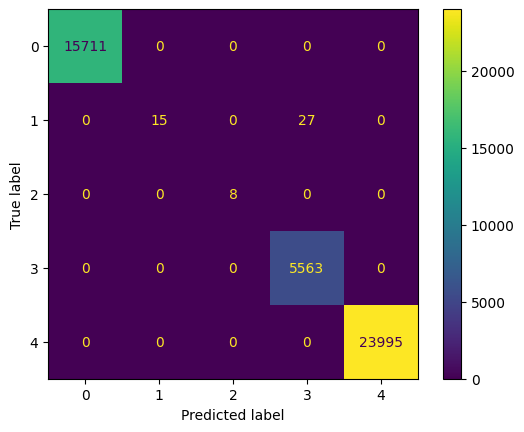

In [13]:
cm = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

print("Labels:")
print("0 --> Benign")
print("1 --> C&C")
print("2 --> C&C FileDownload")
print("3 --> Okiru")
print("4 --> PartOfAHorizontalPortScan")

In [18]:
#using stratified KFold because data is extremely unbalanced
num_splits = 8
kf = StratifiedKFold(n_splits=num_splits,random_state=42,shuffle=True)
scorings = {"acc" : "accuracy", "prec_macro" : "precision_macro", "rec_macro" : "recall_macro" }

In [19]:
scores = cross_validate(scaled_svm, X, Y, scoring = scorings, cv = kf, return_train_score = True)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from numpy.lib import average
print("=======================================================")
i = 0
for i in range(0,num_splits):
  print("Accuracy rating for k={}: {}".format(i+1, scores["test_acc"][i]))
  print("Precision rating for k={}: {}".format(i+1, scores["test_prec_macro"][i]))
  print("Recall rating for k={}: {}".format(i+1, scores["test_rec_macro"][i]))
  print("Training Accuracy rating for k = {}: {}".format(i + 1, scores["train_acc"][i]))
  print("Training Precision rating for k = {}: {}".format(i + 1, scores["train_prec_macro"][i]))
  print("Training Recall rating for k = {}: {}".format(i + 1, scores["train_rec_macro"][i]))

  i += 1
  print("=======================================================")

print("Mean Test Accuracy: {}".format(average(scores["test_acc"])))
print("Mean Test Precision: {}".format(average(scores["test_prec_macro"])))
print("Mean Test Recall: {}".format(average(scores["test_rec_macro"])))
print("\n\n")
print("Mean Training Accuracy: {}".format(average(scores["train_acc"])))
print("Mean Training Precision: {}".format(average(scores["train_prec_macro"])))
print("Mean Training Recall: {}".format(average(scores["train_rec_macro"])))

Accuracy rating for k=1: 0.9994704511755984
Precision rating for k=1: 0.9326436781609196
Recall rating for k=1: 0.9
Training Accuracy rating for k = 1: 0.9993947738723881
Training Precision rating for k = 1: 0.999016836671992
Training Recall rating for k = 1: 0.8873239436619718
Accuracy rating for k=2: 0.9995763609404787
Precision rating for k=2: 0.9993103448275862
Recall rating for k=2: 0.9199999999999999
Training Accuracy rating for k = 2: 0.9993947738723881
Training Precision rating for k = 2: 0.999016836671992
Training Recall rating for k = 2: 0.8873239436619718
Accuracy rating for k=3: 0.9992586316458377
Precision rating for k=3: 0.9323015190599027
Recall rating for k=3: 0.86
Training Accuracy rating for k = 3: 0.9994250351787687
Training Precision rating for k = 3: 0.9990656503565282
Training Recall rating for k = 3: 0.8929577464788732
Accuracy rating for k=4: 0.9996822707053591
Precision rating for k=4: 0.9994827586206896
Recall rating for k=4: 0.9400000000000001
Training Accura